# О проекте

В последние годы криптовалюта стала одним из самых привлекательных классов активов для инвесторов. Резкий рост цен на Биткоин и другие криптовалюты в 2017 году привлек внимание широкой публики к этой новой технологии.
С тех пор рынок криптовалют претерпел значительные изменения, но интерес к инвестициям в эту область остается высоким.

В рамках данного проекта рассматриваются открытые данные о инвестичиях в различные криптовалютные проекты

# Блок импорта

In [1]:
import json
import os
import re
import time

import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import psycopg2
import pycountry
import pydeck as pdk
import requests
import streamlit as st
from geopy.geocoders import Nominatim
from IPython.display import display
from matplotlib.patches import ConnectionPatch
from psycopg2 import Error, sql
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sqlalchemy import Column, create_engine, Float, Integer, String
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker

# Получение и запись данных

пр: данный блок включает в себя парсинг, что занимает много времени - при просмотре проекта выполнение этого блоко можно пропустить или сократить заменив строку "for round in rounds_data['data']:" блока "разбор данных с api на основные элементы" на "for round in rounds_data['data'][:20]:"

достаточный для работы объем данных уже загружен в базу


получение данных по api

In [91]:
rounds = requests.post("https://api.cryptorank.io/v0/funding-rounds-v2")
rounds_data = rounds.json()


разбор данных с api на основные элементы

In [103]:
projects_arr = []
rounds_arr = []
investors_arr = []

for round in rounds_data['data'][:20]:

    projects_arr.append({
        'name': round['name'],
        'key': round['key'],
        'category': round['category']['key'] if round['category'] else 'n/a'
    })
    
    funds = []
    for fund in round.get('funds', []):
        investors_arr.append({
            'fund_name': fund['name'],
            'fund_key': fund['key'],
            'fund_image': fund['image'],
            'fund_tier': fund['tier'],
            'fund_type': fund['type'],
            'fund_category_id': fund['category']['id'] if fund['category'] else 'n/a',
            'fund_category_slug': fund['category']['slug'] if fund['category'] else 'n/a',
            'fund_category_name': fund['category']['name'] if fund['category'] else 'n/a',
            'total_investments': fund['totalInvestments']
        })
        funds.append(fund['key'])

    rounds_arr.append({
        'name': round['name'],
        'key': round['key'],
        'date': round['date'],
        'raise': round['raise'],
        'stage': round['stage'],
        'country': round['country']['key'] if round['country'] else 'n/a',
        'funds': funds
    })

rounds_df = pd.DataFrame(rounds_arr)
projects_df = pd.DataFrame(projects_arr)
investors_df = pd.DataFrame(investors_arr)

полученние уникаьных значений для ключей проектов и инвесторов

In [104]:
projects_df.drop_duplicates(subset=['key'],keep='last')
investors_df.drop_duplicates(subset=['fund_key'],keep='last')

,fund_name,fund_key,fund_image,fund_tier,fund_type,fund_category_id,fund_category_slug,fund_category_name,total_investments
1,Skyview Capital,skyview-capital,https://img.cryptorank.io/funds/60x60.skyview_...,4.0,NORMAL,3,venture,Venture,1
98,Milk Road,milk-road,https://img.cryptorank.io/funds/60x60.milk_roa...,4.0,NORMAL,8,corporate,Corporation,1
99,Rus Yusupov,rus-yusupov,https://img.cryptorank.io/funds/60x60.rus_yusu...,NaN,NORMAL,9,angel-investor,Angel Investor,1
100,Zedd Yin,zedd-yin,https://img.cryptorank.io/funds/60x60.zedd_yin...,NaN,NORMAL,9,angel-investor,Angel Investor,1
143,Ashish Tiwari,ashish-tiwari,https://img.cryptorank.io/funds/60x60.ashish_t...,NaN,NORMAL,9,angel-investor,Angel Investor,1
...,...,...,...,...,...,...,...,...,...
43465,Big Brain Holdings,big-brain-holdings,https://img.cryptorank.io/funds/60x60.big_brai...,3.0,NORMAL,3,venture,Venture,129
43466,Cogitent Ventures,cogitent-venture,https://img.cryptorank.io/funds/60x60.cogitent...,4.0,NORMAL,3,venture,Venture,65
43467,Web3Port,web3port,https://img.cryptorank.io/funds/60x60.web_3_po...,4.0,NORMAL,8,corporate,Corporation,10
43468,Forbole,forbole,https://img.cryptorank.io/funds/60x60.forbole1...,4.0,NORMAL,8,corporate,Corporation,2


добор информации о инвесторах(используем selenium)

In [94]:
# Настройки для Selenium
chrome_options = Options()
chrome_options.add_argument("--headless")  # Отключить отображение браузера
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

# Создание экземпляра браузера
driver = webdriver.Chrome(options=chrome_options)

# Объединенная функция для парсинга страницы фонда
def get_fund_details(fund_key):
    url = f"https://cryptorank.io/funds/{fund_key}"
    driver.get(url)
    time.sleep(2)  # Дать время странице загрузиться

    try:
        # Ищем div с указанным классом и извлекаем URL изображения
        img_div = driver.find_element(
            By.XPATH,
            "//div[@id='__next']/div[@class='sc-89690e04-0 frVnAt']/div[@class='sc-89690e04-1 kVrLIE']"
            "/div[@id='root-container']/div[@class='sc-a9930bdd-0 egkUvd']/div[@class='sc-be4b7d84-0 "
            "sc-b828daee-0 lfEaaA bdQTuL']/img"
        )
        img_url = img_div.get_attribute("src")

        # Идем дальше по дереву и ищем текст в элементе <a> с указанным классом
        a_element = driver.find_element(
            By.XPATH,
            "//div[@id='__next']/div[@class='sc-89690e04-0 frVnAt']/div[@class='sc-89690e04-1 kVrLIE']"
            "/div[@id='root-container']/div[@class='sc-a9930bdd-0 egkUvd']/div[@class='sc-be4b7d84-0 "
            "sc-b828daee-0 lfEaaA bdQTuL']/div[@class='sc-be4b7d84-0 sc-b828daee-2 lfEaaA gxVnFR']"
            "/div[@class='sc-be4b7d84-0 ihTdmH sc-b828daee-9 gyejjv']/a"
        )
        a_text = a_element.text.replace('\n', " ")

        # Ищем первый div с классом "sc-be4b7d84-0 sc-c72ef462-0 lfEaaA brtZCL" для инвестиций
        investment_div = driver.find_element(
            By.XPATH,
            "//div[@id='__next']/div[@class='sc-89690e04-0 frVnAt']/div[@class='sc-89690e04-1 kVrLIE']"
            "/div[@id='root-container']/div[@class='sc-a9930bdd-0 egkUvd']/div[@class='sc-968583a5-0 "
            "toeva']/div[@class='sc-be4b7d84-0 sc-c72ef462-0 lfEaaA brtZCL']"
        )
        investment_p_elements = investment_div.find_elements(By.TAG_NAME, "p")
        investments = investment_p_elements[-1].text if investment_p_elements else ''

        # Ищем второй div с классом 'sc-be4b7d84-0 sc-c72ef462-0 lfEaaA brtZCL' для страны
        target_divs = driver.find_elements(
            By.XPATH,
            "//div[@id='__next']/div[@class='sc-89690e04-0 frVnAt']/div[@class='sc-89690e04-1 kVrLIE']"
            "/div[@id='root-container']/div[@class='sc-a9930bdd-0 egkUvd']/div[@class='sc-968583a5-0 "
            "toeva']/div[@class='sc-be4b7d84-0 sc-c72ef462-0 lfEaaA brtZCL']"
        )

        if len(target_divs) >= 2:
            second_div = target_divs[1]
            country_p_elements = second_div.find_elements(By.TAG_NAME, "p")
            country = country_p_elements[-1].text if (country_p_elements or country_p_elements != 'Jurisdiction:') else ''

            third_div = target_divs[2]
            retail_p_elements = third_div.find_elements(By.TAG_NAME, "p")
            retail_ROI = retail_p_elements[-1].text if retail_p_elements else ''
        else:
            country = ''
            retail_ROI = ''

        time.sleep(5)
        return img_url, a_text, investments, country, retail_ROI

    except Exception as e:
        print(f"Ошибка при парсинге {fund_key}: {e}")
        return '', '', '', '', ''

# Применение функции для каждого фонда в DataFrame
investors_df[['fund_img_url', 'fund_tier', 'fund_investments', 'fund_country', 'fund_retail_ROI']] = investors_df['fund_key'].apply(
    lambda key: pd.Series(get_fund_details(key))
)

# Закрытие браузера
driver.quit()

print(investors_df)


                                    fund_name  \
0                                 A&T Capital   
1                             Skyview Capital   
2                           Multicoin Capital   
3                                  Asymmetric   
4                             Solana Ventures   
...                                       ...   
2093                         Ulmus Investment   
2094                               GameSparks   
2095                                  XSGames   
2096  The Global Emerging Markets Group (GEM)   
2097                                 Adaverse   

                               fund_key  \
0                            at-capital   
1                       skyview-capital   
2                     multicoin-capital   
3                            asymmetric   
4                       solana-ventures   
...                                 ...   
2093                    ulmusinvestment   
2094                        game-sparks   
2095                    

In [ ]:
# Настройки для Selenium
chrome_options = Options()
chrome_options.add_argument("--headless")  # Отключить отображение браузера
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

# Создание экземпляра браузера
driver = webdriver.Chrome(options=chrome_options)

# Объединенная функция для парсинга страницы проекта
def get_project_details(project_key):
    url = f"https://cryptorank.io/price/{project_key}"
    driver.get(url)
    time.sleep(2)  # Дать время странице загрузиться
    try:
        # Ищем первый div с классом "sc-b7cd6de0-0 sc-f084fb54-0 eJnMXZ gQIZzl" для описаний
        description_div = driver.find_element(
            By.XPATH,
            "//div[@id='__next']/div[@class='sc-89690e04-0 frVnAt']/div[@class='sc-89690e04-1 kVrLIE']"
            "/div[@id='root-container']/section[@class='sc-2d06da8a-0 bfGukY']/div[@id='coin-description-block']"
            "/div[@class='sc-be4b7d84-0 sc-76997af6-0 lfEaaA flZSmN']/div[@class='sc-2328569c-0 UDYvf']"
            "/div[@class='sc-7145b3a-0 sc-8095b722-0 iuesNe jVkzVL']/div[@class='sc-b7cd6de0-0 sc-f084fb54-0 eJnMXZ gQIZzl']"
        )
        description_p_elements = description_div.find_elements(By.TAG_NAME, "p")
        description = description_p_elements[-1].text if description_p_elements else ''
        print(description)
        time.sleep(10)
        return description

    except Exception as e:
        print(f"Ошибка при парсинге {project_key}: {e}")
        return '', '', '', '', ''

projects_df['description'] = projects_df['key'].apply(lambda key: pd.Series(get_project_details(key)))[0]


сохраняем данные в тадлицы .xlsx

In [98]:
projects_df.to_excel('project.xlsx')
investors_df.to_excel('investors.xlsx')
rounds_df.to_excel('rounds.xlsx')


подключение к удаленной безе данных и создание таблиц

In [ ]:


# Параметры подключения к базе данных PostgreSQL
conn_params = {
    'dbname':  'crypto_data',
    'user': 'crypto_data',
    'password': '11223344task',
    'host': '95.163.223.37',
    'port': '6432'
}

try:
    # Подключение к базе данных
    conn = psycopg2.connect(**conn_params)
    conn.autocommit = True
    cursor = conn.cursor()

    # SQL запросы для создания таблиц
    create_projects_table = """
    CREATE TABLE IF NOT EXISTS projects (
        id SERIAL PRIMARY KEY,
        name VARCHAR(255),
        key VARCHAR(255) UNIQUE,
        category VARCHAR(255),
        description TEXT
    );
    """

    create_rounds_table = """
    CREATE TABLE IF NOT EXISTS rounds (
        id SERIAL PRIMARY KEY,
        name VARCHAR(255),
        key VARCHAR(255),
        date DATE,
        raise DECIMAL(20, 2),
        stage VARCHAR(255),
        country VARCHAR(255),
        project_key VARCHAR(255),
        FOREIGN KEY (project_key) REFERENCES projects(key)
    );
    """

    create_investors_table = """
    CREATE TABLE IF NOT EXISTS investors (
        id SERIAL PRIMARY KEY,
        project_name VARCHAR(255),
        name VARCHAR(255),
        key VARCHAR(255),
        image VARCHAR(255),
        tier VARCHAR(255),
        type VARCHAR(255),
        category_id VARCHAR(255),
        category_slug VARCHAR(255),
        category_name VARCHAR(255),
        total_investments DECIMAL(20, 2),
        investment DECIMAL(20, 2),
        country VARCHAR(255),
        retail_ROI DECIMAL(20, 2)
    );
    """

    create_investor_round_table = """
    CREATE TABLE IF NOT EXISTS investor_round (
        investor_id INT,
        round_id INT,
        FOREIGN KEY (investor_id) REFERENCES investors(id),
        FOREIGN KEY (round_id) REFERENCES rounds(id),
        PRIMARY KEY (investor_id, round_id)
    );
    """

    # Выполнение SQL запросов
    cursor.execute(create_projects_table)
    cursor.execute(create_rounds_table)
    cursor.execute(create_investors_table)
    cursor.execute(create_investor_round_table)

    print("Tables created successfully.")

except (Exception, Error) as error:
    print("Error while creating PostgreSQL tables:", error)

finally:
    # Закрытие соединения и курсора
    if cursor:
        cursor.close()
    if conn:
        conn.close()

сзоздание функций для записи данных в бд

In [99]:


# Параметры подключения к базе данных PostgreSQL
conn_params = {
    'dbname':  'crypto_data',
    'user': 'crypto_data',
    'password': '11223344task',
    'host': '95.163.223.37',
    'port': '6432'
}

def connect_db():
    return psycopg2.connect(**conn_params)

# Функции для импорта данных из DataFrame в базу данных
def import_investors(df):
    conn = connect_db()
    cursor = conn.cursor()
    try:
        for index, row in df.iterrows():
            cursor.execute("""
                INSERT INTO investors (name, key, image, tier, type, category_id, category_slug, category_name, total_investments, investment, country, retail_ROI)
                VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
                """, (
                row['fund_name'], row['fund_key'], row['fund_image'], row['fund_tier'], row['fund_type'],
                row['fund_category_id'], row['fund_category_slug'], row['fund_category_name'],
                row['total_investments'], row['fund_investments'], row['fund_country'], row['fund_retail_ROI']
            ))
        conn.commit()
    except (Exception, Error) as error:
        print("Error while importing investors:", error)
    finally:
        cursor.close()
        conn.close()

def import_projects(df):
    conn = connect_db()
    cursor = conn.cursor()
    try:
        for index, row in df.iterrows():
            cursor.execute("""
                INSERT INTO projects (name, key, category, description)
                VALUES (%s, %s, %s, %s)
                ON CONFLICT (key) DO NOTHING
                """, (
                row['name'], row['key'], row['category'], row['description']
            ))
        conn.commit()
    except (Exception, Error) as error:
        print("Error while importing projects:", error)
    finally:
        cursor.close()
        conn.close()

def import_rounds(df):
    conn = connect_db()
    cursor = conn.cursor()
    try:
        for index, row in df.iterrows():
            # Ensure the project key exists in the projects table
            cursor.execute("SELECT id FROM projects WHERE key = %s", (row['key'],))
            project = cursor.fetchone()
            if project:
                project_key = row['key']
                cursor.execute("""
                    INSERT INTO rounds (name, key, date, raise, stage, country, project_key)
                    VALUES (%s, %s, %s, %s, %s, %s, %s)
                    RETURNING id
                    """, (
                    row['name'], row['key'], row['date'], row['raise'], row['stage'], row['country'], project_key
                ))
                round_id = cursor.fetchone()[0]
                funds = row['funds'].strip("[]").replace("'", "").split(', ')
                for fund_key in funds:
                    cursor.execute("SELECT id FROM investors WHERE key = %s", (fund_key,))
                    investor = cursor.fetchone()
                    if investor:
                        cursor.execute("""
                            INSERT INTO investor_round (investor_id, round_id)
                            VALUES (%s, %s)
                            """, (investor[0], round_id))
            else:
                print(f"Project key {row['key']} not found in projects table.")
        conn.commit()
    except (Exception, Error) as error:
        print("Error while importing rounds:", error)
    finally:
        cursor.close()
        conn.close()

прочтение данных из xlsx таблиц, применение необьходимых изменений и запись их в базу с установкой необходимых отношений

In [102]:
investors_df = pd.read_excel(r'investors.xlsx').drop_duplicates()
projects_df = pd.read_excel(r'project.xlsx').drop_duplicates()
rounds_df = pd.read_excel(r'rounds.xlsx').drop_duplicates()

# Функция для перевода кода страны в полное название
def translate_country_code(code):
    if pd.isna(code):
        return None
    try:
        country = pycountry.countries.get(alpha_2=code)
        if country:
            return country.name
        else:
            return None
    except:
        return None

def correctform(value):
    return re.sub(r'x', '', value)

# Применение функции к столбцу DataFrame
investors_df['fund_retail_ROI'] = investors_df['fund_retail_ROI'].apply(correctform)
# Применение функции к столбцу country
rounds_df['country'] = rounds_df['country'].apply(translate_country_code)
investors_df['country'] = investors_df['fund_country'].apply(translate_country_code)

import_investors(investors_df)
import_projects(projects_df)
import_rounds(rounds_df)

# Создание классов аналитических блоков 

аналогичные блоки испорльзуются для визуализации на stramlit

блок кластеризации

In [52]:
class ClusteringBlock:
    def __init__(self, db_engine):
        self.db_engine = db_engine
        self.data = self.load_data()

    def load_data(self):
        query = """
        SELECT 
            i.id AS investor_id,
            i.name AS investor_name,
            COUNT(ir.round_id) AS total_rounds,
            SUM(r.raise) AS total_investment,
            AVG(r.raise) AS avg_investment_per_round,
            AVG(
                CASE r.stage
                    WHEN 'Seed' THEN 1
                    WHEN 'Series A' THEN 2
                    WHEN 'Series B' THEN 3
                    WHEN 'Series C' THEN 4
                    ELSE 5
                END
            ) AS avg_stage,
            i.country AS investor_country
        FROM 
            investors i
        JOIN 
            investor_round ir ON i.id = ir.investor_id
        JOIN 
            rounds r ON ir.round_id = r.id
        GROUP BY 
            i.id, i.name, i.country;
        """
        return pd.read_sql(query, self.db_engine)

    def preprocess_data(self):
        # Удаление столбцов, где все значения пустые
        self.data.dropna(axis=1, how='all', inplace=True)

        # Удаление строк, где есть хотя бы одно пустое значение
        self.data.dropna(inplace=True)

    def render(self,n_clusters = 5):
        # Выбор количества кластеров

        # Кнопка для запуска кластеризации

        self.preprocess_data()

        # Применение K-means кластеризации
        kmeans = KMeans(n_clusters=n_clusters)
        features = self.data[
            ['total_rounds', 'total_investment', 'avg_investment_per_round', 'avg_stage']
        ]
        self.data['cluster'] = kmeans.fit_predict(features)


        # Визуализация кластеров
        fig = px.scatter(
            self.data,
            x='total_investment',
            y='avg_investment_per_round',
            color='cluster',
            hover_data=['investor_name'],
            title='Кластеры инвесторов'
        )
        display(fig)
        return self.data

блок информации о раундах, в которых участвовал инвестоп

In [53]:
class GroupInvestorBlock:
    def __init__(self, engine):
        self.engine = engine
        self.rounds_by_country_df = self.load_data(self.query_rounds_by_country)
        self.rounds_by_stage_df = self.load_data(self.query_rounds_by_stage)
        self.project_categories_df = self.load_data(self.query_project_categories)

    query_rounds_by_country = """
        SELECT
            i.id AS investor_id,
            i.name AS investor_name,
            r.country,
            COUNT(DISTINCT r.id) AS num_rounds
        FROM
            investors AS i
        JOIN
            investor_round AS ir ON i.id = ir.investor_id
        JOIN
            rounds AS r ON ir.round_id = r.id
        GROUP BY
            i.id, i.name, r.country;
    """

    query_rounds_by_stage = """
        SELECT
            i.id AS investor_id,
            i.name AS investor_name,
            r.stage,
            COUNT(DISTINCT r.id) AS num_rounds
        FROM
            investors AS i
        JOIN
            investor_round AS ir ON i.id = ir.investor_id
        JOIN
            rounds AS r ON ir.round_id = r.id
        GROUP BY
            i.id, i.name, r.stage;
    """

    query_project_categories = """
        SELECT
            i.id AS investor_id,
            i.name AS investor_name,
            p.category,
            COUNT(p.category) AS category_count
        FROM
            investors AS i
        JOIN
            investor_round AS ir ON i.id = ir.investor_id
        JOIN
            rounds AS r ON ir.round_id = r.id
        JOIN
            projects AS p ON r.project_key = p.key
        GROUP BY
            i.id, i.name, p.category;
    """

    def load_data(self, query):
        return pd.read_sql(query, self.engine)

    def filter_data(self):
        
        investor_options = self.rounds_by_country_df['investor_name'].unique()
        selected_investors = investor_options
        self.rounds_by_country_df = self.rounds_by_country_df[
            self.rounds_by_country_df['investor_name'].isin(selected_investors)
        ]
        self.rounds_by_stage_df = self.rounds_by_stage_df[
            self.rounds_by_stage_df['investor_name'].isin(selected_investors)
        ]
        self.project_categories_df = self.project_categories_df[
            self.project_categories_df['investor_name'].isin(selected_investors)
        ]


    def combine_small_categories(self, data, threshold=5):
        total = data.sum()
        combined_data = data.copy()
        small_categories = data[data / total * 100 < threshold]
        if not small_categories.empty:
            combined_data = combined_data.drop(small_categories.index)
            combined_data['Другие'] = small_categories.sum()
        return combined_data

    def group_data(self):
        group_rounds_by_country_df = self.rounds_by_country_df.groupby('country')['num_rounds'].sum()
        group_rounds_by_stage_df = self.rounds_by_stage_df.groupby('stage')['num_rounds'].sum()
        group_project_categories_df = self.project_categories_df.groupby('category')['category_count'].sum()

        group_rounds_by_country_df = self.combine_small_categories(group_rounds_by_country_df)
        group_rounds_by_stage_df = self.combine_small_categories(group_rounds_by_stage_df)
        group_project_categories_df = self.combine_small_categories(group_project_categories_df)

        return group_rounds_by_country_df, group_rounds_by_stage_df, group_project_categories_df

    def create_annotated_pie(self, ax, data, title, labels):
        wedges, texts, autotexts = ax.pie(
            data,
            labels=None,
            autopct=lambda pct: f"{pct:.1f}%",
            wedgeprops=dict(width=0.6),
            textprops=dict(color='black'),
            pctdistance=0.8
        )
        ax.set_title(title, fontsize=12)

        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
        kw = dict(bbox=bbox_props, zorder=0, va="center")

        for i, p in enumerate(wedges):
            ang = (p.theta2 - p.theta1) / 2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            annotation_text = (
                f"{labels[i]}\n{data[i]} rounds\n({data[i] / data.sum() * 100:.1f}%)"
            )
            ax.annotate(
                annotation_text, xy=(x, y), xytext=(1.35 * np.sign(x), 1.4 * y),
                horizontalalignment=horizontalalignment, **kw
            )

            con = ConnectionPatch(
                xyA=(x, y), coordsA=ax.transData,
                xyB=(1.35 * np.sign(x), 1.4 * y), coordsB=ax.transData,
                arrowstyle="-", lw=1, color='black'
            )
            ax.add_artist(con)

    def plot_data(self):
        group_rounds_by_country_df, group_rounds_by_stage_df, group_project_categories_df = self.group_data()

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        self.create_annotated_pie(
            axes[0], group_rounds_by_country_df, "Страны", group_rounds_by_country_df.index
        )
        self.create_annotated_pie(
            axes[1], group_rounds_by_stage_df, "Стадии", group_rounds_by_stage_df.index
        )
        self.create_annotated_pie(
            axes[2], group_project_categories_df, "Категории", group_project_categories_df.index
        )

        fig.tight_layout()
        display(fig)

    def render(self):
        self.filter_data()
        self.plot_data()

блок информации об инвесторах

In [54]:
class InvestorBlock:
    def __init__(self, engine):
        self.engine = engine
        self.investors_df = self.load_data()

    def load_data(self):
        investor_query = "SELECT * FROM investors;"
        return pd.read_sql(investor_query, self.engine)

    def plot_pie_charts(self, filtered_data):
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        
        self.plot_pie_chart(axes[0], filtered_data, 'tier', 'Уровни', threshold_percentage=3)
        self.plot_pie_chart(axes[1], filtered_data, 'country', 'Страны', threshold_percentage=3)
        
        plt.tight_layout()
        display(fig)

    def plot_pie_chart(self, ax, data, column, title, threshold_percentage=5):
        value_counts = data[column].value_counts().sort_values(ascending=False)
        threshold = (threshold_percentage / 100) * value_counts.sum()
        other_counts = value_counts[value_counts < threshold].sum()
        value_counts = value_counts[value_counts >= threshold]
        if other_counts >= 0.01:
            value_counts['Другие'] = other_counts
        
        ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
        ax.set_title(title)

    def render(self):
        filtered_data = filtered_data = self.investors_df
        try:
            if len(filtered_data) != 0:
                self.plot_pie_charts(filtered_data)
            else:
                return -1
        except Exception as e:
           print(f'Ошибка при построении графиков: {e}')

представление информации на карте

In [98]:
Base = declarative_base()

class CountryCoord(Base):
    __tablename__ = 'country_coord'
    id = Column(Integer, primary_key=True)
    country_name = Column(String, unique=True, nullable=False)
    longitude = Column(Float, nullable=False)
    latitude = Column(Float, nullable=False)
    
class MapBlock:
    def __init__(self, engine):
        rounds_query = "SELECT name, country FROM rounds;"
        investors_query = "SELECT name, country FROM investors;"
        self.rounds_df = pd.read_sql(rounds_query, engine)
        self.investors_df = pd.read_sql(investors_query, engine)
        self.df = pd.DataFrame()
        self.geolocator = Nominatim(user_agent="abc")
        self.engine = engine
        Base.metadata.create_all(self.engine)
        Session = sessionmaker(bind=self.engine)
        self.session = Session()
        self.country_list = self.get_country_list()

    def get_country_list(self):
        # Читаем данные из базы данных в DataFrame
        df = pd.read_sql_table('country_coord', self.engine)
        return {row['country_name']: (row['longitude'], row['latitude']) for index, row in df.iterrows()}

    def get_country_coordinates(self, country_name):
        if pd.notna(country_name) and country_name != "NaN":
            
            if country_name=="Greece":
                location = self.country_list.get(country_name)
            if country_name=="Turkey":
                location = self.country_list.get(country_name)
            location = self.country_list.get(country_name)
            if location:
                return [location[0], location[1]]
            else:
                # Если координаты не найдены в БД, ищем через geopy и сохраняем в БД
                geopy_location = self.geolocator.geocode(country_name)
                if geopy_location:
                    longitude = geopy_location.longitude
                    latitude = geopy_location.latitude
                    # Создаем DataFrame для новой записи
                    new_country_df = pd.DataFrame([{
                        'country_name': country_name,
                        'longitude': longitude,
                        'latitude': latitude
                    }])
                    # Сохраняем новую запись в базу данных
                    new_country_df.to_sql('country_coord', self.engine, if_exists='append', index=False)
                    return [longitude, latitude]
        return None
    

    def render(self):
        points = []
        self.investors_df = self.investors_df.dropna()
        self.rounds_df = self.rounds_df.dropna()
        country_investors = {}
        country_rounds = {}

        for _, row in self.investors_df.iterrows():
            country = row['country']
            if country == "NaN":
                continue
            investment = row['name']
            if country in country_investors:
                country_investors[country].append(investment)
            else:
                country_investors[country] = [investment]

        for _, row in self.rounds_df.iterrows():
            country = row['country']
            if country == "NaN":
                continue
            round_name = row['name']
            if country in country_rounds:
                country_rounds[country].append(round_name)
            else:
                country_rounds[country] = [round_name]

        for country in set(country_investors.keys()).union(set(country_rounds.keys())):
            investors = country_investors.get(country, [])
            rounds = country_rounds.get(country, [])
            count = len(investors) + len(rounds)
            text_parts = []
            if investors:
                text_parts.append(f"Investors: {', '.join(investors)}")
            if rounds:
                text_parts.append(f"Rounds: {', '.join(rounds)}")
            text = "; ".join(text_parts)
            coordinates = self.get_country_coordinates(country)
            if coordinates:
                points.append({
                    "country": country,
                    "count": count,
                    "text_info": text,
                    "coordinates": coordinates
                })

        self.df = pd.DataFrame(points)

        view_state = pdk.ViewState(
            latitude=20.0,
            longitude=0.0,
            zoom=1,
            pitch=50  # Увеличиваем pitch для 3D эффекта
        )

        # Функция для определения цвета в зависимости от count
        def get_color(count):
            if count < 5:
                return [255, 0, 0, 128]  # Полупрозрачный красный
            elif count < 10:
                return [255, 165, 0, 128]  # Полупрозрачный оранжевый
            else:
                return [0, 128, 0, 128]  # Полупрозрачный зеленый

        # Добавляем цвет в DataFrame
        self.df['color'] = self.df['count'].apply(get_color)

        layer = pdk.Layer(
            'ScatterplotLayer',
            data=self.df,
            get_position='coordinates',
            get_radius='100000',
            get_fill_color='color',
            pickable=True,
            auto_highlight=True,
        )

        deck = pdk.Deck(
            initial_view_state=view_state,
            layers=[layer],
            tooltip={"text": "Общее кол-во: {count}\n{text_info}"}
        )

        display(deck)

C:\Users\Loinos\AppData\Local\Temp\ipykernel_5880\1325017770.py:1: MovedIn20Warning:

The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)



блок прогнозирования

In [102]:
class PredictionBlock:
    def __init__(self, engine):
        self.engine = engine
        self.data = self.load_data()

    def load_data(self):
        rounds_query = """
        SELECT date_trunc('month', date) AS month, COUNT(*) AS rounds
        FROM rounds
        GROUP BY 1
        ORDER BY 1;
        """
        df = pd.read_sql(rounds_query, self.engine)
        df['month'] = pd.to_datetime(df['month'])
        
        # Определение выбросов с использованием IQR
        Q1 = df['rounds'].quantile(0.25)
        Q3 = df['rounds'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Фильтрация выбросов
        df = df[(df['rounds'] >= lower_bound) & (df['rounds'] <= upper_bound)]
        return df


    def render(self):
        # Слайдер для выбора количества месяцев для анализа
        months_for_analysis = 12

        # Слайдер для выбора количества месяцев для прогнозирования
        months_for_forecast = 3

        # Чекбоксы для выбора методов прогнозирования
        methods = ["Случайный лес","Градиентный бустинг","Линейная регрессия"]

        predict_data =[]
        # Проверка на выбор всех необходимых параметров
        if months_for_analysis and months_for_forecast and methods:
            forecast_dfs, mses, r2s = self.predict(months_for_analysis, months_for_forecast, methods)
            for i, (method, forecast_df) in enumerate(forecast_dfs.items()):
                

                fig, ax = plt.subplots(figsize=(10, 5))
                chart_data = forecast_df.set_index('Month')[['Actual', 'Forecast']].clip(lower=0)  # Убираем отрицательные значения

                # Добавление третьей с конца точки реальных данных к прогнозируемым значениям
                third_last_actual = chart_data['Actual'].iloc[-3]
                forecast_with_start = pd.concat([pd.Series([third_last_actual], index=[chart_data.index[-3]]), chart_data['Forecast']])

                ax.plot(chart_data.index, chart_data['Actual'], label='Actual', color='blue')
                ax.plot(forecast_with_start.index, forecast_with_start.values, label='Forecast', color='green', linestyle='--')
                ax.vlines(forecast_with_start.index, 0, forecast_with_start.values, colors='red', linestyles='dotted', linewidth=0.5)
                ax.set_title(f"Метод: {method}\nMSE: {mses[method]:.2f} R²: {r2s[method]:.2f}")
                ax.set_xlabel("Месяц")
                ax.set_ylabel("Количество раундов")
                ax.legend()
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
                ax.xaxis.set_minor_locator(mdates.MonthLocator())
                fig.autofmt_xdate()
                display(fig)
                predict_data.append({'fig':fig,'forecast_df':forecast_df})
        return predict_data

    def predict(self, months_for_analysis, months_for_forecast, methods):
        # Заполнение отсутствующих месяцев нулями
        self.data.set_index('month', inplace=True)
        self.data = self.data.asfreq('MS').fillna(0).reset_index()

        # Обрезка последних 2 месяцев для дополнительного прогнозирования
        train_data = self.data.iloc[:-2]
        test_data = self.data.iloc[-2:]

        # Подготовка обучающих данных
        X_train = np.arange(len(train_data) - months_for_analysis, len(train_data)).reshape(-1, 1)
        y_train = train_data['rounds'][-months_for_analysis:]

        # Инициализация словарей для хранения прогнозов и метрик
        forecasts = {}
        mses = {}
        r2s = {}

        for method in methods:
            # Выбор модели
            if method == "Случайный лес":
                model = RandomForestRegressor()
            elif method == "Градиентный бустинг":
                model = GradientBoostingRegressor()
            else:
                model = LinearRegression()

            # Обучение модели
            model.fit(X_train, y_train)

            # Прогнозирование последних 2 месяцев необрезанной даты
            X_test = np.arange(len(train_data), len(train_data) + 2).reshape(-1, 1)
            y_test_pred = model.predict(X_test)

            # Вычисление метрик
            mse = mean_squared_error(test_data['rounds'], y_test_pred)
            r2 = r2_score(test_data['rounds'], y_test_pred)
            mses[method] = mse
            r2s[method] = r2

            # Подготовка данных для прогнозирования указанных месяцев
            pred_data = self.data.copy()
            pred_data['Forecast'] = np.nan
            pred_data.loc[len(train_data):len(train_data) + 1, 'Forecast'] = y_test_pred

            # Прогнозирование указанных месяцев
            X_future = np.arange(len(train_data) + 2, len(train_data) + 2 + months_for_forecast).reshape(-1, 1)
            y_future_pred = model.predict(X_future)
            future_dates = pd.date_range(start=pred_data['month'].iloc[-1] + pd.DateOffset(months=1), periods=months_for_forecast, freq='MS')
            future_df = pd.DataFrame({'month': future_dates, 'rounds': np.nan, 'Forecast': y_future_pred})

            # Объединение данных
            pred_data = pd.concat([pred_data, future_df], ignore_index=True)

            # Переименование столбца для графика
            pred_data.rename(columns={'month': 'Month', 'rounds': 'Actual'}, inplace=True)

            forecasts[method] = pred_data

        return forecasts, mses, r2s

блок информации о проектах

In [57]:
class ProjectInvestorBlock:
    def __init__(self, engine):
        self.engine = engine
        self.investors_project_df = self.load_data()

    def load_data(self):
        query_investors_project = """
            SELECT 
                i.name AS investor_name,
                p.name AS project_name,
                r.name AS round_name,
                r.date AS round_date,
                r.raise AS round_raise,
                r.stage AS round_stage,
                r.country AS round_country
            FROM 
                investors i
            JOIN 
                investor_round ir ON i.id = ir.investor_id
            JOIN 
                rounds r ON ir.round_id = r.id
            JOIN 
                projects p ON r.project_key = p.key
            ORDER BY 
                i.name, p.name, r.date;
        """
        return pd.read_sql(query_investors_project, self.engine)

    def plot_graph(self, filtered_df):
        G = nx.Graph()
        unique_stages = self.investors_project_df['round_stage'].unique()
        colors = list(mcolors.TABLEAU_COLORS.values())
        stage_colors = {stage: colors[i % len(colors)] for i, stage in enumerate(unique_stages)}

        for _, row in filtered_df.iterrows():
            investor = row['investor_name']
            project = row['project_name']
            stage = row['round_stage']
            G.add_node(investor, type='investor')
            G.add_node(project, type='project')
            G.add_edge(investor, project, stage=stage)

        pos = nx.spring_layout(G, dim=3)  # 3D layout

        # Extract 3D positions
        x_nodes = [pos[node][0] for node in G.nodes()]
        y_nodes = [pos[node][1] for node in G.nodes()]
        z_nodes = [pos[node][2] for node in G.nodes()]

        edge_trace = []
        for stage, color in stage_colors.items():
            edge_x = []
            edge_y = []
            edge_z = []
            for u, v in G.edges():
                if G[u][v]['stage'] == stage:
                    edge_x.extend([pos[u][0], pos[v][0], None])
                    edge_y.extend([pos[u][1], pos[v][1], None])
                    edge_z.extend([pos[u][2], pos[v][2], None])
            edge_trace.append(go.Scatter3d(x=edge_x, y=edge_y, z=edge_z, mode='lines', line=dict(color=color, width=2), name=stage))

        node_colors = ['lightblue' if G.nodes[node]['type'] == 'investor' else 'lightgreen' for node in G]
        node_trace = go.Scatter3d(
            x=x_nodes,
            y=y_nodes,
            z=z_nodes,
            mode='markers+text',
            marker=dict(size=10, color=node_colors, opacity=0.8),
            text=[node for node in G.nodes()],
            textposition='top center'
        )

        layout = go.Layout(
            title='3D Graph of Investors and Projects',
            showlegend=True,
            legend=dict(x=0, y=1),
            margin=dict(l=0, r=0, b=0, t=40),
            hovermode='closest'
        )

        fig = go.Figure(data=edge_trace + [node_trace], layout=layout)
        display(fig)

    def render(self):
        filtered_df = self.investors_project_df
        try:
            if not filtered_df.empty:
                self.plot_graph(filtered_df)
            else:
                return -1
        except Exception as e:
            print(f'Ошибка: {e}')

блок информации о раундах

In [58]:
class RoundBlock:
    def __init__(self, engine):
        self.engine = engine
        self.rounds_df = self.load_data()
    
    def load_data(self):
        rounds_query = "SELECT * FROM rounds;"
        return pd.read_sql(rounds_query, self.engine).dropna()
        
    def plot_pie_charts(self, filtered_data):
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        
        self.plot_pie_chart(
            axes[0], 
            filtered_data, 
            'country', 
            'Страны', 
            threshold_percentage=3
        )
        
        self.plot_pie_chart(
            axes[1], 
            filtered_data, 
            'stage', 
            'Стадии', 
            threshold_percentage=3
        )
        
        plt.tight_layout()
        display(fig)
    
    def plot_pie_chart(self, ax, data, column, title, threshold_percentage=5):
        value_counts = data[column].value_counts().sort_values(ascending=False)
        threshold = (threshold_percentage / 100) * value_counts.sum()
        other_counts = value_counts[value_counts < threshold].sum()
        value_counts = value_counts[value_counts >= threshold]
        if other_counts >= 0.01:
            value_counts['Другие'] = other_counts
        
        ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
        ax.set_title(title)
    
    def render(self):
        filtered_data = self.rounds_df
        
        try:
            if len(filtered_data) != 0:
                self.plot_pie_charts(filtered_data)
            else:
                return -1
        except Exception as e:
            print(f'Ошибка при построении графиков: {e}')

# Визуализация

In [59]:
class visualApp:
    def __init__(self):
        self.title = "Crypto Analytic"
        self.blocks = []

    def add_block(self, block):
        self.blocks.append(block)

    def render_blocks(self):
        for block in self.blocks:
            block.render()

    def run(self):
        st.title(self.title)
        self.render_blocks()
        
    def create_db_engine(self):
        DB_NAME='crypto_data'
        DB_USER='crypto_data'
        DB_PASSWORD='11223344task'
        DB_HOST='95.163.223.37'
        DB_PORT='6432'
        db_url = (
            f"postgresql://{DB_USER}:{DB_PASSWORD}"
            f"@{DB_HOST}:{DB_PORT}/{DB_NAME}"
        )
        return create_engine(db_url)

In [103]:
app = visualApp()
engine = app.create_db_engine()

clustering_block = ClusteringBlock(engine)
map_block = MapBlock(engine)
round_block = RoundBlock(engine)
investor_block = InvestorBlock(engine)
prediction_block = PredictionBlock(engine)
group_investor = GroupInvestorBlock(engine)
project_investor = ProjectInvestorBlock(engine)



граф связи инвесторов и проектов

In [79]:
%matplotlib notebook 
project_investor.render()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'line': {'color': '#1f77b4', 'width': 2},
              'mode': 'lines',
              'name': 'SEED',
              'type': 'scatter3d',
              'x': [0.1861826479434967, 0.13715749979019165, None, ...,
                    -0.38464421033859253, -0.3789609372615814, None],
              'y': [-0.14597369730472565, -0.11551651358604431, None, ...,
                    0.03534941375255585, 0.03404675051569939, None],
              'z': [0.055265460163354874, 0.03590388596057892, None, ...,
                    0.9772117733955383, 0.9685698747634888, None]},
             {'line': {'color': '#ff7f0e', 'width': 2},
              'mode': 'lines',
              'name': 'SERIES A',
              'type': 'scatter3d',
              'x': [0.035700321197509766, 0.026689786463975906, None, ...,
                    0.6979644894599915, 0.6915820837020874, None],
              'y': [-0.036646634340286255, -0.03574663773179054, None, ...,
                    -0.44264283776283264, -0.45040279626846313, None],
              'z': [0.17411287128925323, 0.11231324821710587, None, ...,
                    -0.5678945183753967, -0.5690023899078369, None]},
             {'line': {'color': '#2ca02c', 'width': 2},
              'mode': 'lines',
              'name': 'PRE SEED',
              'type': 'scatter3d',
              'x': [0.03156695514917374, 0.022096820175647736, None, ...,
                    0.1940750777721405, 0.20211735367774963, None],
              'y': [0.2684576213359833, 0.2367371767759323, None, ...,
                    0.4368026852607727, 0.4526498019695282, None],
              'z': [-0.38651904463768005, -0.35331520438194275, None, ...,
                    0.604180097579956, 0.6256210803985596, None]},
             {'line': {'color': '#d62728', 'width': 2},
              'mode': 'lines',
              'name': 'Undisclosed',
              'type': 'scatter3d',
              'x': [-0.11744467914104462, -0.11652937531471252, None, ...,
                    -0.12883497774600983, -0.12372999638319016, None],
              'y': [-0.177810937166214, -0.21702255308628082, None, ...,
                    -0.660358726978302, -0.6663745641708374, None],
              'z': [-0.05818251892924309, -0.09129726141691208, None, ...,
                    -0.5601530075073242, -0.5510307550430298, None]},
             {'line': {'color': '#9467bd', 'width': 2},
              'mode': 'lines',
              'name': 'STRATEGIC',
              'type': 'scatter3d',
              'x': [-0.03104119747877121, 0.015290345065295696, None, ...,
                    -0.48459112644195557, -0.497126966714859, None],
              'y': [0.013049697503447533, -0.02825375460088253, None, ...,
                    0.5591000914573669, 0.5662445425987244, None],
              'z': [-0.006089142058044672, -0.005070209968835115, None, ...,
                    -0.40611815452575684, -0.4091155230998993, None]},
             {'line': {'color': '#8c564b', 'width': 2},
              'mode': 'lines',
              'name': 'SERIES B',
              'type': 'scatter3d',
              'x': [-0.1960582733154297, -0.23378807306289673, None, ...,
                    0.980987548828125, 0.9959879517555237, None],
              'y': [0.11890341341495514, 0.15840210020542145, None, ...,
                    -0.11924456059932709, -0.12250293046236038, None],
              'z': [0.00873732753098011, 0.024674290791153908, None, ...,
                    0.11227536201477051, 0.116683728992939, None]},
             {'line': {'color': '#e377c2', 'width': 2},
              'mode': 'lines',
              'name': 'Private Token Sale',
              'type': 'scatter3d',
              'x': [0.04479200392961502, 0.030822571367025375, None,
                    0.030822571367025375, 0.023577142506837845, None,
                    0.030822571367025375, 0.034232448786497116, None,
                    0.030822571367025375, 0.03148107975721359, None,
                    0.030822571367025

кластеризация инвесторов

In [78]:
%matplotlib notebook 
clustering_block.render()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'customdata': array([['DWF Labs'],
                                   ['Palumni VC'],
                                   ['DegenDaVinci'],
                                   ...,
                                   ['QCP Capital'],
                                   ['Lightspeed Venture Partners'],
                                   ['BH Digital']], dtype=object),
              'hovertemplate': ('total_investment=%{x}<br>avg_i' ... '%{marker.color}<extra></extra>'),
              'legendgroup': '',
              'marker': {'color': array([3, 3, 3, ..., 0, 2, 0]), 'coloraxis': 'coloraxis', 'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'showlegend': False,
              'type': 'scattergl',
              'x': array([5.0000e+06, 5.6000e+06, 2.2000e+06, ..., 9.0000e+07, 1.1848e+09,
                          8.0000e+07]),
              'xaxis': 'x',
              'y': array([5.00000000e+06, 5.60000000e+06, 1.10000000e+06, ..., 2.25000000e+07,
                          1.07709091e+08, 4.00000000e+07]),
              'yaxis': 'y'}],
    'layout': {'coloraxis': {'colorbar': {'title': {'text': 'cluster'}},
                             'colorscale': [[0.0, '#000011'], [0.1111111111111111,
                                            '#000012'], [0.2222222222222222,
                                            '#000013'], [0.3333333333333333,
                                            '#000014'], [0.4444444444444444,
                                            '#000015'], [0.5555555555555556,
                                            '#000016'], [0.6666666666666666,
                                            '#000017'], [0.7777777777777778,
                                            '#000018'], [0.8888888888888888,
                                            '#000019'], [1.0, '#000020']]},
               'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Кластеры инвесторов'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'total_investment'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'avg_investment_per_round'}}}
})

,investor_id,investor_name,total_rounds,total_investment,avg_investment_per_round,avg_stage,investor_country,cluster
0,1798,DWF Labs,1,5.000000e+06,5.000000e+06,5.0,Singapore,3
1,1489,Palumni VC,1,5.600000e+06,5.600000e+06,5.0,United States,3
2,652,DegenDaVinci,2,2.200000e+06,1.100000e+06,5.0,NaN,3
3,273,PrimeBlock Ventures,6,4.400000e+07,7.333333e+06,5.0,Singapore,3
4,51,GFR Fund,2,2.580000e+07,1.290000e+07,5.0,United States,3
...,...,...,...,...,...,...,...,...
1184,530,P2 Ventures (Polygon Ventures),13,2.377000e+08,1.828462e+07,5.0,United States,0
1185,536,Sarmayacar,2,5.000000e+07,2.500000e+07,5.0,Pakistan,3
1186,520,QCP Capital,4,9.000000e+07,2.250000e+07,5.0,Singapore,0
1187,55,Lightspeed Venture Partners,11,1.184800e+09,1.077091e+08,5.0,United States,2


распределение раундов инвестиций по странам стадиям и категориям

<IPython.core.display.Javascript object>

C:\Users\Loinos\AppData\Local\Temp\ipykernel_5880\728729427.py:116: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



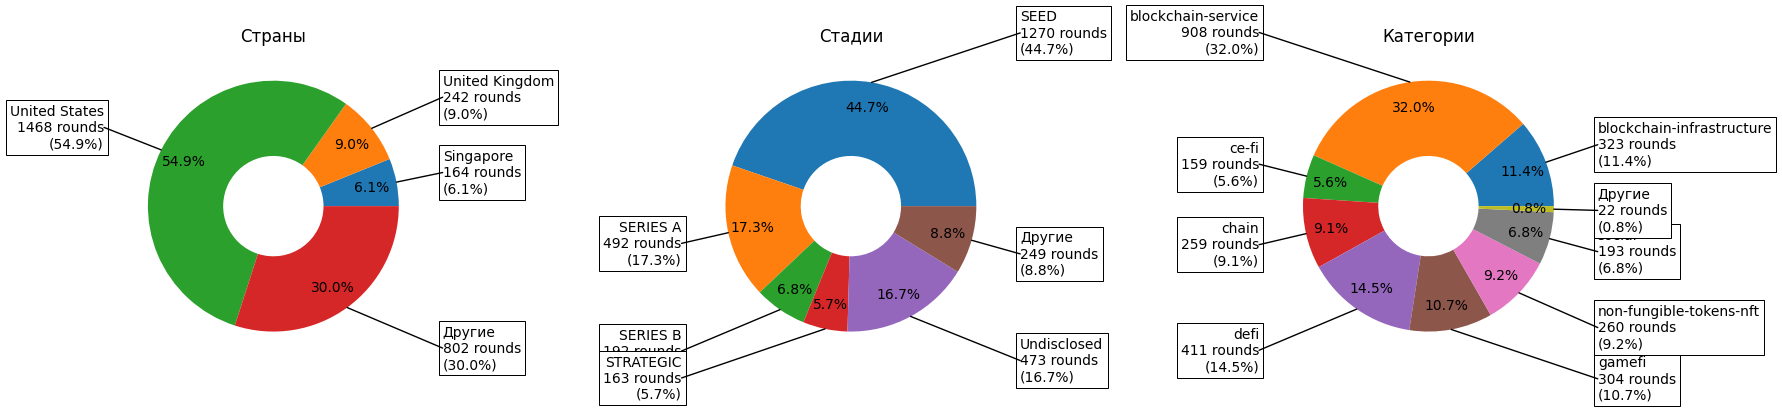

In [77]:
%matplotlib notebook 
group_investor.render()

распределения инвесторов по их уровню и стране

<IPython.core.display.Javascript object>

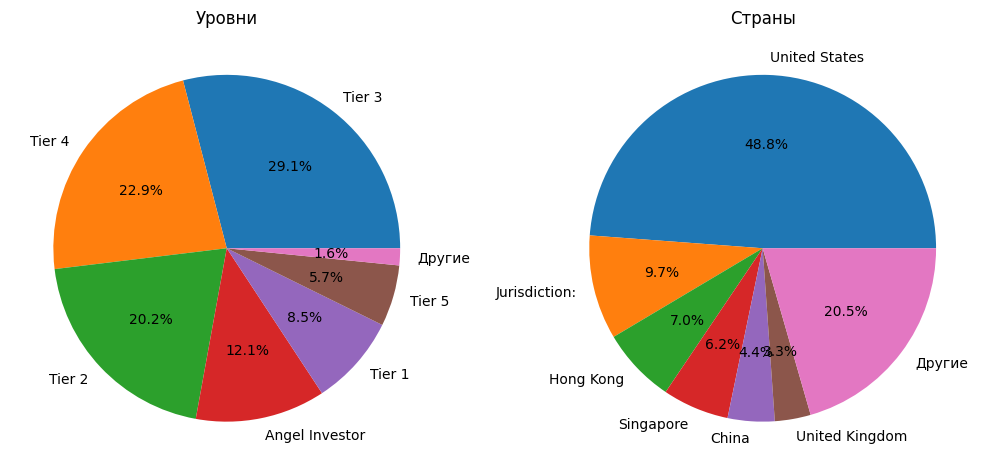

In [76]:
%matplotlib notebook 
investor_block.render()

распределение раундов инвестиции по стране и стадии

<IPython.core.display.Javascript object>

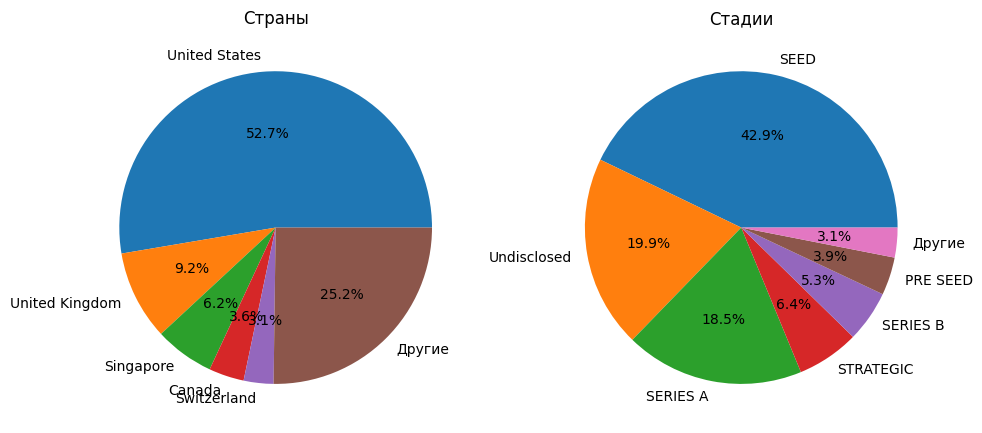

In [75]:
%matplotlib notebook 
round_block.render()

распределение информации на карте мира

In [100]:
%matplotlib notebook 
map_block.render()

{
  "initialViewState": {
    "latitude": 20.0,
    "longitude": 0.0,
    "pitch": 50,
    "zoom": 1
  },
  "layers": [
    {
      "@@type": "ScatterplotLayer",
      "autoHighlight": true,
      "data": [
        {
          "color": [
            255,
            0,
            0,
            128
          ],
          "coordinates": [
            -53.2,
            -10.3333333
          ],
          "count": 3,
          "country": "Brazil",
          "text_info": "Investors: Ita\u00fa, Ita\u00fa, Uniera"
        },
        {
          "color": [
            0,
            128,
            0,
            128
          ],
          "coordinates": [
            107.9650855,
            15.9266657
          ],
          "count": 16,
          "country": "Vietnam",
          "text_info": "Investors: Infinity Capital, 4SV, GFS Ventures, GFS Ventures, 4SV, 4SV, Infinity Capital, 4SV, GFS Ventures, GFS Ventures, 4SV, 4SV, FEBE Ventures, Megala Ventures, Kyros Ventures, Ancient8"
        },
        {
          "color": [
            0,
            128,
            0,
            128
          ],
          "coordinates": [
            124.724704,
            7.4931858
          ],
          "count": 13,
          "country": "Thailand",
          "text_info": "Investors: PrimeStreet Capital, Bank of Ayudhya, Kasikornbank, Varys Capital, PrimeStreet Capital, Bank of Ayudhya, Kasikornbank, Varys Capital, Galaxy Ventures, GuildFi, GuildFi; Rounds: Forward, Forward"
        },
        {
          "color": [
            0,
            128,
            0,
            128
          ],
          "coordinates": [
            -3.2765753,
            54.7023545
          ],
          "count": 128,
          "country": "United Kingdom",
          "text_info": "Investors: Fabric Ventures, Santiago R. Santos, KR1, Arweave, Marshall Wace, Blockchain.com, Arweave, Semantic Ventures, Crane Venture Partners, Eterna Capital, Kestrel 0x1, Sarah Drinkwater, Outlier Ventures, Ref Finance, LRC Group, Polymorphic Capital, Archax, Cogitent Ventures, RSS3, Jets Capital, Dan Houser, Arweave, Double Down, Eterna Capital, Fabric Ventures, Santiago R. Santos, KR1, Arweave, Marshall Wace, Blockchain.com, Arweave, Semantic Ventures, Crane Venture Partners, Eterna Capital, Kestrel 0x1, Sarah Drinkwater, Outlier Ventures, Ref Finance, LRC Group, Polymorphic Capital, Archax, Cogitent Ventures, RSS3, Jets Capital, Dan Houser, Arweave, Double Down, Eterna Capital, Firstminute capital, Fabric Ventures, Third Kind Games, Fabric Ventures, Moonfire Ventures, Brevan Howard Digital, Blockchain.com, Fabric Ventures, Semantic Ventures, Wintermute, Nexo, Dmitry Tokarev, Blockchain.com, Stani Kulechov, Molten Ventures, Entrepreneur First, 2050 Capital, Fabric Ventures, Mint Ventures, Blockchain.com, CoinShares, Anthony Beaumont, Dominance Ventures, Fabric Ventures, Fabric Ventures, BACKED, MH Ventures, Firstminute capital, Libertus Capital, Entrepreneur First, MH Ventures, Kingsway Capital, Santiago R. Santos, Fabric Ventures, Index Ventures, Fasanara Capital, Brevan Howard Digital, Westridge Markets, Mirabaud Asset Management, NxGen, Fabric Ventures, AngelDAO, LocalGlobe, 7percent Ventures, Deeptech Labs, Ian Hogarth, Tom Blomfield; Rounds: Hubble Protocol, Rated, Mailchain, Ownera, Exchange Art, Bundlr Network, KYVE Network, KYVE Network, KYVE Network, Distributed Finance, Hubble Protocol, Rated, Mailchain, Ownera, Exchange Art, Bundlr Network, KYVE Network, KYVE Network, KYVE Network, Distributed Finance, Infinity Exchange, Revolut, Hadean, Old Street Digital, DFX Finance, Fair.xyz, MPCH Labs, Gatenox, dNo, Fanzee, Sumo Signals, Sweat Economy, Condense"
        },
        {
          "color": [
            0,
            128,
            0,
            128
          ],
          "coordinates": [
            8.2319736,
            46.7985624
          ],
          "count": 48,
          "country": "Switzerland",
          "text_info": "Investors: Bitscale Capital, FunPlus, Num

блок предсказания

<IPython.core.display.Javascript object>

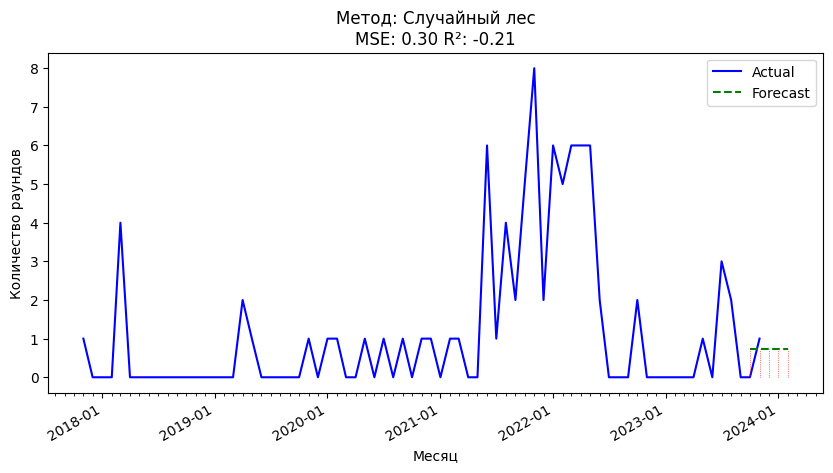

<IPython.core.display.Javascript object>

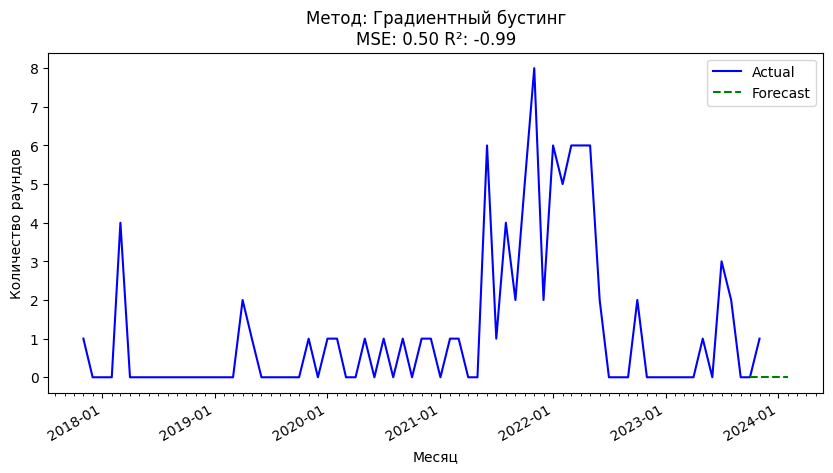

<IPython.core.display.Javascript object>

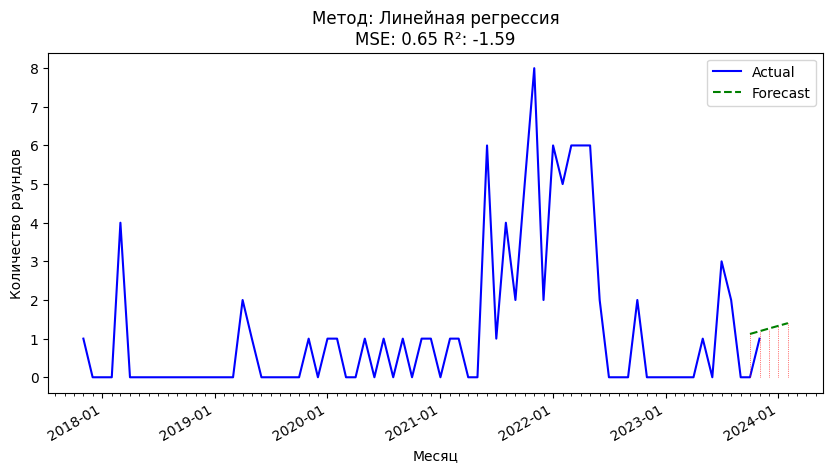

[{'fig': <Figure size 1000x500 with 1 Axes>,
  'forecast_df':                        Month  Actual  Forecast
  0  2017-11-01 00:00:00+00:00     1.0       NaN
  1  2017-12-01 00:00:00+00:00     0.0       NaN
  2  2018-01-01 00:00:00+00:00     0.0       NaN
  3  2018-02-01 00:00:00+00:00     0.0       NaN
  4  2018-03-01 00:00:00+00:00     4.0       NaN
  ..                       ...     ...       ...
  71 2023-10-01 00:00:00+00:00     0.0      0.73
  72 2023-11-01 00:00:00+00:00     1.0      0.73
  73 2023-12-01 00:00:00+00:00     NaN      0.73
  74 2024-01-01 00:00:00+00:00     NaN      0.73
  75 2024-02-01 00:00:00+00:00     NaN      0.73
  
  [76 rows x 3 columns]},
 {'fig': <Figure size 1000x500 with 1 Axes>,
  'forecast_df':                        Month  Actual  Forecast
  0  2017-11-01 00:00:00+00:00     1.0       NaN
  1  2017-12-01 00:00:00+00:00     0.0       NaN
  2  2018-01-01 00:00:00+00:00     0.0       NaN
  3  2018-02-01 00:00:00+00:00     0.0       NaN
  4  2018-03-01 00

In [104]:
%matplotlib notebook 
prediction_block.render()

#ВАЖНО! гораздо удобнее всю информацию можно посмотреть на streamlit http://95.163.223.37:8501/ , также там можно установить фильтры для таблиц и графиков